# 3. Metabolic task

A Metabolc task were first defined in Thiele and coworkers (2013):

*“metabolic task as a nonzero flux through a reaction or through a pathway leading to the production of a metabolite B from a metabolite A. The metabolic capacity of the network was demonstrated by testing nonzero flux values for these metabolic tasks. For each of the simulations, a steady-state flux distribution was calculated. Each metabolic task was optimized individually by choosing the corresponding reaction in the model, if present, as objective function and maximized the flux through the reaction”.*

It was then be emphasized in this research:
https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006867


In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path("../../").resolve()))

%load_ext autoreload
%autoreload 2

In [3]:
import copy
import numpy as np
import seaborn as sns
import pipeGEM as pg

from pipeGEM.analysis.tasks import TaskContainer, TASKS_FILE_PATH
from pipeGEM.data.synthesis import get_syn_gene_data


## Load existing task file

In [21]:
tasks = TaskContainer.load(TASKS_FILE_PATH)

In [5]:
for i, (task_id, task) in enumerate(tasks.items()):
    if i == 3:
        break
    print(f"Task ID: {task_id}", '\n', task)

Task ID: 1.0 
 system : ENERGY METABOLISM
subsystem : OXYDATIVE PHOSPHORYLATION
description : Oxidative phosphorylation via NADH-coenzyme Q oxidoreductase (COMPLEX I)
should fail : False
----- input metabolites -----

---------------------------------------
|     Met ID|      LB|      UB|   comp|
---------------------------------------
|   MAM03103|   1.000|   1.000|      m|
|   MAM02553|   1.000|   1.000|      m|
|   MAM02039|   5.000|   5.000|      m|
---------------------------------------

----- output metabolites -----

---------------------------------------
|     Met ID|      LB|      UB|   comp|
---------------------------------------
|   MAM03102|   1.000|   1.000|      m|
|   MAM02552|   1.000|   1.000|      m|
|   MAM02039|   4.000|   4.000|      i|
---------------------------------------

Task ID: 2.0 
 system : ENERGY METABOLISM
subsystem : OXYDATIVE PHOSPHORYLATION
description : Oxidative phosphorylation via succinate-coenzyme Q oxidoreductase (COMPLEX II)
should fail : F

## Manipulating a task

In [7]:
print(tasks["1.0"])

system : ENERGY METABOLISM
subsystem : OXYDATIVE PHOSPHORYLATION
description : Oxidative phosphorylation via NADH-coenzyme Q oxidoreductase (COMPLEX I)
should fail : False
----- input metabolites -----

---------------------------------------
|     Met ID|      LB|      UB|   comp|
---------------------------------------
|   MAM03103|   1.000|   1.000|      m|
|   MAM02553|   1.000|   1.000|      m|
|   MAM02039|   5.000|   5.000|      m|
---------------------------------------

----- output metabolites -----

---------------------------------------
|     Met ID|      LB|      UB|   comp|
---------------------------------------
|   MAM03102|   1.000|   1.000|      m|
|   MAM02552|   1.000|   1.000|      m|
|   MAM02039|   4.000|   4.000|      i|
---------------------------------------



In [31]:
new_task = copy.deepcopy(tasks["1"])

In [33]:
new_task.in_mets, new_task.out_mets

([{'met_id': 'q10', 'lb': 1.0, 'ub': 1.0, 'compartment': 'm'},
  {'met_id': 'nadh', 'lb': 1.0, 'ub': 1.0, 'compartment': 'm'},
  {'met_id': 'h', 'lb': 5.0, 'ub': 5.0, 'compartment': 'm'}],
 [{'met_id': 'q10h2', 'lb': 1.0, 'ub': 1.0, 'compartment': 'm'},
  {'met_id': 'nad', 'lb': 1.0, 'ub': 1.0, 'compartment': 'm'},
  {'met_id': 'h', 'lb': 4.0, 'ub': 4.0, 'compartment': 'c'}])

In [34]:
new_task.in_mets.append({"met_id": 'glc_D', 'lb': 0, 'ub': 10, 'compartment': 'c'})
new_task.out_mets.append({"met_id": 'co2', 'lb': 0, 'ub': 10, 'compartment': 'c'})
print(new_task)

system : ENERGY METABOLISM
subsystem : OXYDATIVE PHOSPHORYLATION
description : Oxidative phosphorylation via NADH-coenzyme Q oxidoreductase (COMPLEX I)
should fail : False
----- input metabolites -----

--------------------------------------
|   Met ID|      LB|       UB|   comp|
--------------------------------------
|      q10|   1.000|    1.000|      m|
|     nadh|   1.000|    1.000|      m|
|        h|   5.000|    5.000|      m|
|    glc_D|   0.000|   10.000|      c|
--------------------------------------

----- output metabolites -----

--------------------------------------
|   Met ID|      LB|       UB|   comp|
--------------------------------------
|    q10h2|   1.000|    1.000|      m|
|      nad|   1.000|    1.000|      m|
|        h|   4.000|    4.000|      c|
|      co2|   0.000|   10.000|      c|
--------------------------------------



In [35]:
# add to a task container
new_tasks = TaskContainer()
new_tasks["1"] = new_task

# you can use it to do the following task testing

## Test the loaded tasks

In [14]:
from pipeGEM.data.fetching import load_remote_model
from pipeGEM.data import GeneData

In [19]:
human1 = pg.Model("human", load_remote_model("Human-GEM"))

Model Human-GEM is already downloaded


In [22]:
human1.add_tasks("general",  # the name of your task
                 tasks)  # TaskContainer containing the tasks

In [11]:
data = np.log2(get_syn_gene_data(human1, n_sample=3) + 1)

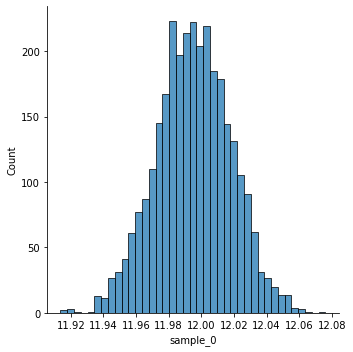

In [12]:
sns.displot(data["sample_0"])

In [13]:
data.head()

,sample_0,sample_1,sample_2
ENSG00000197894,11.977280,12.027906,12.032046
ENSG00000196616,12.031012,11.959640,11.983350
ENSG00000180011,12.001056,12.000000,11.999295
ENSG00000147576,12.038919,11.969027,12.036174
ENSG00000198099,11.997532,11.993646,12.002112


In [23]:
gene_data = GeneData(data=data["sample_0"], 
                     data_transform=lambda x: np.log2(x), 
                     absent_expression=0)
p90_threshold = gene_data.get_threshold("percentile", p=90)

human1.add_tasks("general", tasks)
human1.add_gene_data("sample_0", gene_data)

In [24]:
task_analysis_result = human1.test_tasks("general", 
                                         model_compartment_parenthesis="{}")

Task 61.0 cannot support tasks' metabolites
Task 64.0 cannot support tasks' metabolites
Task 70.0 cannot support tasks' metabolites
Task 72.0 cannot support tasks' metabolites
Task 77.0 cannot support tasks' metabolites
Task 90.0 cannot support tasks' metabolites
Task 119.0 cannot support tasks' metabolites
Task 164.0 cannot support tasks' metabolites
Task 169.0 cannot support tasks' metabolites
Task 172.0 cannot support tasks' metabolites
Task 174.0 cannot support tasks' metabolites
Task 181.0 cannot support tasks' metabolites
Task 194.0 cannot support tasks' metabolites
score of the model: 182 / 195


C:\Users\qwert\PycharmProjects\pipeGEM\pipeGEM\analysis\results\task.py:85: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._task_support_rxns = dict(self._result_df["task_support_rxns"].iteritems())
C:\Users\qwert\PycharmProjects\pipeGEM\pipeGEM\analysis\results\task.py:86: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._task_support_rxn_fluxes = dict(self._result_df["task_support_rxn_fluxes"].iteritems())
C:\Users\qwert\PycharmProjects\pipeGEM\pipeGEM\analysis\results\task.py:87: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._rxn_supps = dict(self._result_df["rxn_supps"].iteritems())


In [26]:
task_analysis_result.result_df

,Passed,Should fail,Missing mets,Status,Obj_value,Obj_rxns,task_support_rxns,task_support_rxn_fluxes,Sink Status,rxn_supps
1.0,True,False,False,optimal,6.0,"[output_MAM03102m: MAM03102m --> , output_MAM0...",[MAR06921],{'MAR06921': 1.0},optimal,"[MAR03854, MAR04143, MAR08506, MAR08508, MAR04..."
2.0,True,False,False,optimal,2.0,"[output_MAM01862m: MAM01862m --> , output_MAM0...",[MAR08743],{'MAR08743': -1.0},optimal,"[MAR04652, MAR08743, MAR06911]"
3.0,True,False,False,optimal,3.0,"[output_MAM01261m: MAM01261m --> , output_MAM0...",[MAR04137],{'MAR04137': 1.0},optimal,"[MAR04137, MAR08514, MAR04280, MAR04461, MAR03..."
4.0,True,False,False,optimal,10.0,"[output_MAM01597m: MAM01597m --> , output_MAM0...","[MAR03957, MAR04141, MAR04145, MAR04147, MAR04...","{'MAR03957': 1.0, 'MAR04141': -1.0, 'MAR04145'...",optimal,"[MAR04280, MAR05351, MAR04018, MAR07801, MAR03..."
5.0,True,False,False,optimal,72.0,"[output_MAM01371c: MAM01371c --> , output_MAM0...","[MAR04137, MAR04388, MAR04301, MAR04358, MAR04...","{'MAR04137': 2.0000000000000004, 'MAR04388': 2...",optimal,"[MAR04137, MAR04388, MAR04301, MAR04358, MAR04..."
...,...,...,...,...,...,...,...,...,...,...
191.0,True,False,False,optimal,3.0,"[output_MAM03000g: MAM03000g --> , output_MAM0...",[MAR01353],{'MAR01353': 1.0},optimal,"[MAR04363, MAR04365, MAR04368, MAR04373, MAR04..."
192.0,True,False,False,optimal,23.0,"[output_MAM02288g: MAM02288g --> , output_MAM0...","[MAR07442, MAR07443, MAR07444, MAR07445, MAR07...","{'MAR07442': 1.0, 'MAR07443': 1.0, 'MAR07444':...",optimal,"[MAR04388, MAR04355, MAR04363, MAR04365, MAR04..."
193.0,True,False,False,optimal,25.0,"[output_MAM02303g: MAM02303g --> , output_MAM0...","[MAR07471, MAR07472, MAR07473, MAR07474, MAR07...","{'MAR07471': 1.0, 'MAR07472': 1.0, 'MAR07473':...",optimal,"[MAR04388, MAR04355, MAR04363, MAR04365, MAR04..."
194.0,False,False,False,optimal,57.0,"[output_MAM00141l: MAM00141l --> , output_MAM0...","[MAR04379, MAR04358, MAR04360, MAR04363, MAR04...","{'MAR04379': 7.5, 'MAR04358': 11.25, 'MAR04360...",support rxns infeasible,NaN


In [27]:
# saving the result as a json file
task_analysis_result.save("./task_result.json")

## Get activated tasks and supported reactions

In [33]:
activated_tasks = human1.get_activated_tasks("sample_0", task_analysis_result, score_threshold=p90_threshold.exp_th)
activated_task_sup_rxns = human1.get_activated_task_sup_rxns("sample_0", task_analysis_result, score_threshold=p90_threshold.exp_th)

In [37]:
activated_tasks[:10]

['7.0', '22.0', '31.0', '39.0', '46.0', '57.0', '58.0', '60.0', '63.0', '79.0']

In [36]:
activated_task_sup_rxns[:10]

['MAR06052',
 'MAR04295',
 'MAR04629',
 'MAR04832',
 'MAR09272',
 'MAR11385',
 'MAR08950',
 'MAR06510',
 'MAR03780',
 'MAR11147']